In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas_datareader import data
import scipy.optimize as sco

In [3]:
"""Define parameters for data request."""

tickers = ['AGG', 'EBND', 'URTH', 'EEM']
data_source = 'yahoo'
start_date = '2014-03-31'
end_date = '2018-03-31'

In [4]:
"""Request data, ensure sorted by ascending date, and normalise."""

panel_data = data.DataReader(tickers, data_source, start_date, end_date)
px_data = panel_data.loc['Adj Close'].dropna().sort_index(ascending=True)
px_data = px_data / px_data.iloc[0]

In [5]:
"""View data."""

px_data.head()

,AGG,EBND,EEM,URTH
Date,,,,
2014-03-31,1.000000,1.000000,1.000000,1.000000
2014-04-01,0.998467,1.004047,1.011705,1.000983
2014-04-02,0.996796,1.000675,1.013655,1.003652
2014-04-03,0.997539,0.998314,1.009754,0.993819
2014-04-04,1.000696,1.003710,1.007071,0.987358


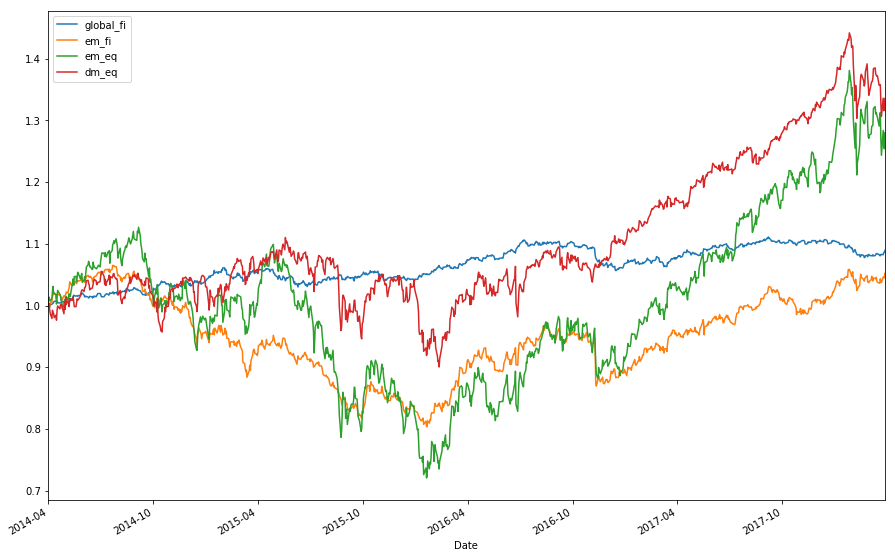

In [6]:
"""Rename and plot."""

px_data.columns = ['global_fi', 'em_fi', 'em_eq', 'dm_eq']
px_data.plot(figsize=(15, 10));

# KEY POINTS

>Broad asset classes ETFs are used as an example here.

>Depending on the ETF/share class, some distribute income and others accumulate. This means some returns may be price return only and not capture the total return.

In [7]:
"""Calculate summary statistics needed for optimisation targets."""

def summary_stats(w, df, data_type='Price', rf=0, scaling_fact=252):
    
    """Converts df of prices to df of ln returns."""
    if data_type == 'Price':
        ln_ret = np.log(df/df.shift(1))
    else:
        ln_ret = df
    
    """Expected return target (based on historical mean)."""
    er = np.dot(w, ln_ret.mean()) * scaling_fact
    
    """Historical max drawdown."""
    ret = ((np.exp(ln_ret) - 1) * w).sum(axis=1).add(1).cumprod()
    dd = ret.div(ret.cummax()).sub(1)
    mdd = dd.min()
    
    """Marginal risk, risk contribution, and risk parity target."""
    mvar = np.dot(w, ln_ret.cov().T) * w * scaling_fact
    pvar = sum(mvar)
    r_con = mvar / pvar
    rp_target = sum((pvar/len(w) - mvar)**2) * 10000 #Scale up by 10000 to make the optimisation easier
    
    """Portfolio volatility target and diversification ratio target."""
    pvol_target = pvar ** 0.5
    dr_target = sum((w * ln_ret.std() * 252 ** 0.5)) / pvol_target
    
    """Sharpe ratio target."""
    sr = (er - rf) / pvol_target
    
    results = {
        'exp_return': er,
        'volatility': pvol_target,
        'sharpe_ratio': sr,
        'max_drawdown': mdd,
        'risk_contribution': r_con,
        'risk_parity': rp_target,
        'diversification_ratio': dr_target
    }
    
    return results

In [8]:
"""Objective functions for portfolio optimisation."""

def max_er(w, df, data_type='Price', rf=0, scaling_fact=252):
    return -summary_stats(w, df, data_type='Price', rf=0, scaling_fact=252)['exp_return']

def min_vol(w, df, data_type='Price', rf=0, scaling_fact=252):
    return summary_stats(w, df, data_type='Price', rf=0, scaling_fact=252)['volatility']

def max_sr(w, df, data_type='Price', rf=0, scaling_fact=252):
    return -summary_stats(w, df, data_type='Price', rf=0, scaling_fact=252)['sharpe_ratio']

def risk_parity(w, df, data_type='Price', rf=0, scaling_fact=252):
    return summary_stats(w, df, data_type='Price', rf=0, scaling_fact=252)['risk_parity']

def max_dr(w, df, data_type='Price', rf=0, scaling_fact=252):
    return -summary_stats(w, df, data_type='Price', rf=0, scaling_fact=252)['diversification_ratio']

In [9]:
"""Create wrapper for scipy optimisation."""

def port_optimisation(func, df, bounds=None, constraints=(), data_type='Price', rf=0, scaling_fact=252):
    """
    Not really needed, just makes working with scipy a little easier.
    SLSQP selected as method as we will be working with equality constraints.
    
    """
    w = [1/len(df.columns) for x in df.columns]
    
    r = sco.minimize(
        func, w, 
        args=(df, data_type, rf, scaling_fact),
        method='SLSQP', 
        bounds=bounds, constraints=constraints
    ) 
    
    w = r.x
    
    s = summary_stats(w, df, data_type='Price', rf=0, scaling_fact=252)
    
    stats = {
        'exp_return': s['exp_return'],
        'volatility': s['volatility'],
        'sharpe_ratio': s['sharpe_ratio'],
        'max_drawdown': s['max_drawdown']
    }
    
    results = {
        'weights': w,
        'summary_stats': stats,
        'success': r.success    
    }
    
    print('{} Success=={} after {} iterations.'.format(r.message, r.success, r.nit))
    
    return results

In [10]:
"""
TEST CASE
Add constraints: Portfolio weights must sum to 100%, minimum ann. return > 3.0%,
Add boundaries: Long only, no short positions.
"""

min_ret = 0.04

constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'ineq', 'fun': lambda w: summary_stats(w, px_data)['exp_return'] - min_ret}
)

bounds = tuple((0, 1) for x in px_data.columns)

In [11]:
%%time
"""Run optimisation for risk parity."""

opt_res = port_optimisation(risk_parity, px_data, bounds=bounds, constraints=constraints)
opt_w = opt_res['weights']
opt_stats = opt_res['summary_stats']

Optimization terminated successfully. Success==True after 8 iterations.
Wall time: 229 ms


In [12]:
"""View weights."""

pd.options.display.float_format = '{:,.4f}'.format
df_w = pd.DataFrame(opt_w, index=px_data.columns, columns=['weights'])
df_w['vol_contrib'] = pd.DataFrame(summary_stats(opt_w, px_data)['risk_contribution'], index=px_data.columns)
df_w

,weights,vol_contrib
global_fi,0.6096,0.0654
em_fi,0.0000,0.0000
em_eq,0.1239,0.3616
dm_eq,0.2664,0.5730


In [13]:
"""View statistics."""

pd.options.display.float_format = '{:,.4f}'.format
df_w = pd.DataFrame([opt_stats], columns=opt_stats.keys(), index=['summary_stats']).T
df_w

,summary_stats
exp_return,0.0400
volatility,0.0566
sharpe_ratio,0.7061
max_drawdown,-0.0921


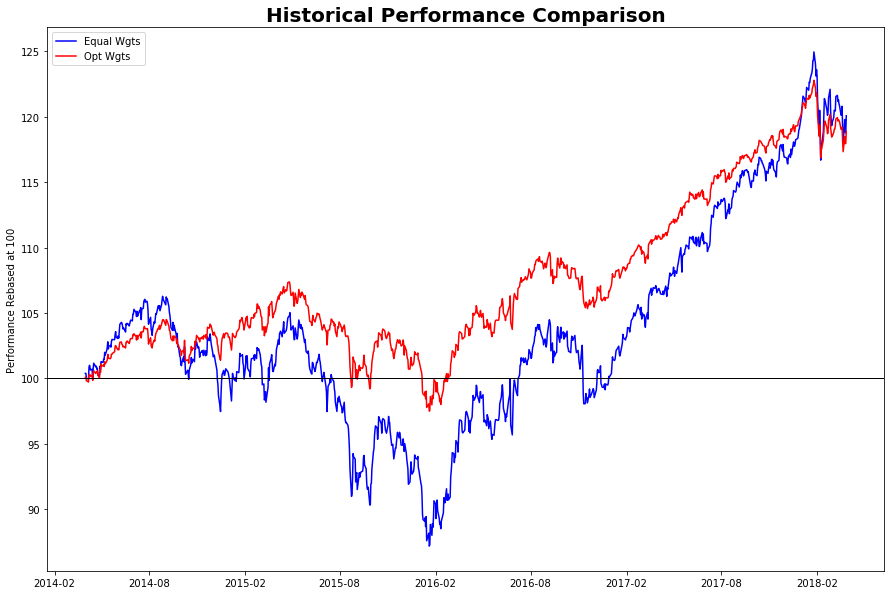

In [14]:
"""inspect the historical time series (assumes rebalancing to current daily, very basic)."""

returns = px_data.pct_change()

equal_wgts_ts = (returns.mean(axis=1).add(1)).cumprod() * 100
opt_wgts_ts = (pd.DataFrame(np.dot(returns, opt_w)).add(1)).cumprod() * 100
x = returns.index

plt.figure(figsize=(15, 10))
plt.plot(x, equal_wgts_ts, label='Equal Wgts', c='b')
plt.plot(x, opt_wgts_ts, label='Opt Wgts', c='r')
plt.axhline(y=100, linewidth=1, color = 'black')
plt.title('Historical Performance Comparison', fontsize=20, fontweight='bold')
plt.ylabel('Performance Rebased at 100')
plt.legend(loc='best')
plt.show()

# KEY POINTS

## Using risk parity underperforms equal weights during between 2014 - 2018 but with a much lower drawdown.

> In order to achieve equal risk contribution, the riskier asset classes are given a lower weighing. During the sample period almost all risk assets have performed extremely well, suggesting risk parity may not be appropriate for investors seeking high returns in the middle of the bull run.

> Note, the backtest results are in sample. This results in significant bias and should not be done in practice. When checking how an optimisation may have performed historically, use walk-forward optimisation in order to avoid such bias.

> Daily rebalancing is unrealistic as trading costs would erode returns. Depending on the investor, monthly, quarterly or even annual rebalancing may be more appropriate.